In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

plt.style.use('bmh')

In [61]:
def generate_stationary_phi(nvars, nlags, sparsity_threshold):
    """
    Generate a stationary phi matrix for VAR process with sparsity.
    
    Parameters:
    - nvars: Number of time series.
    - nlags: Number of lags.
    - sparsity_threshold: Threshold below which coefficients are set to zero.
    
    Returns:
    - phi: Stationary and sparse coefficient matrix of shape (nvars, nvars * nlags).
    """
    max_attempts = 1000
    attempt = 0
    
    while attempt < max_attempts:
        phi = np.random.randn(nvars, nvars * nlags) * 0.1
        
        # Induce sparsity
        phi[np.abs(phi) < sparsity_threshold] = 0
        
        # Companion form
        companion = np.zeros((nvars * nlags, nvars * nlags))
        companion[:nvars, :] = phi
        companion[nvars:, :-nvars] = np.eye((nlags - 1) * nvars)
        
        eigenvalues = np.linalg.eigvals(companion)
        
        if np.all(np.abs(eigenvalues) < 1):
            # All eigenvalues inside the unit circle implies stationarity
            return phi
        
        attempt += 1
    
    raise ValueError(f"Failed to find stationary phi matrix in {max_attempts} attempts")


def simulate_VAR(T=100, nvars=2, nlags=1, sparsity_threshold=0.05, seed=None, phi=None, c=None):
    """
    Simulate a VAR process.
    
    Parameters:
    - T: Number of observations.
    - nvars: Number of time series.
    - nlags: Number of lags.
    - phi: Coefficient matrix. If None, a stationary matrix is generated.
    - c: Constant vector. If None, a default vector is used.
    
    Returns:
    - data: Simulated data of shape (T, nvars).
    """
    
    if seed is not None:
        np.random.seed(seed)  # Seed for reproducibility

    if phi is None:
        phi = generate_stationary_phi(nvars, nlags, sparsity_threshold)
    
    if c is None:
        c = np.zeros(nvars)
    
    # Initialize
    data = np.zeros((T, nvars))
    epsilons = np.random.randn(T, nvars)
    
    for t in range(nlags, T):
        for l in range(nlags):
            data[t] += np.dot(phi[:, nvars*l:nvars*(l+1)], data[t-l-1])
        data[t] += c + epsilons[t]
    
    return data, phi

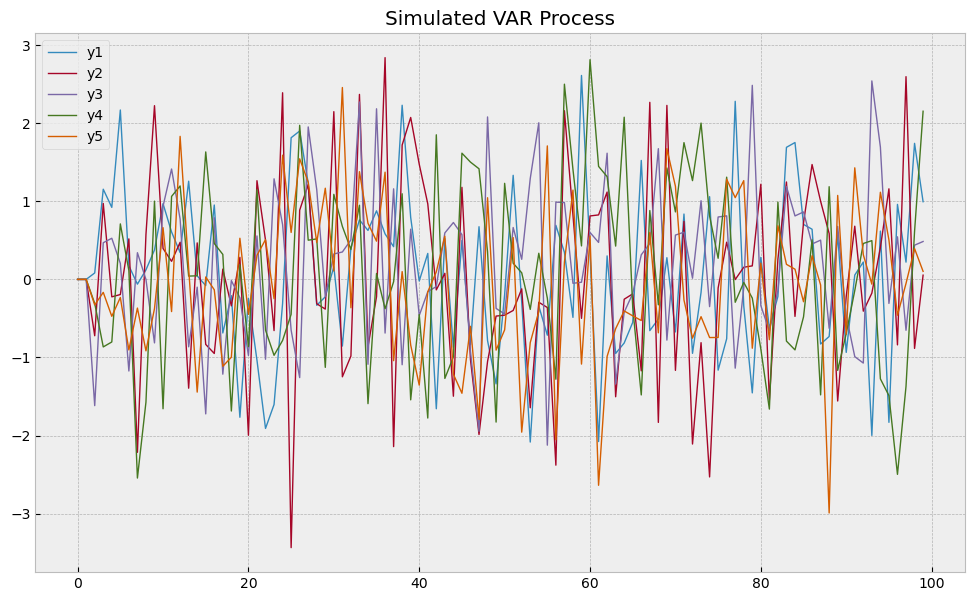

In [80]:
T = 100
seed = None
lags = 2
eqs = 5
sparsity = 1-0.95

# simulate data
var_sim, phi = simulate_VAR(T=T, nvars=eqs, nlags=lags, sparsity_threshold=sparsity, seed=seed)

# plot the simulated data
plt.figure(figsize=(12, 7))
for i in range(var_sim.shape[1]):
    plt.plot(var_sim[:, i], label=f"y{i+1}", linewidth=1)
plt.legend()
plt.title("Simulated VAR Process")
plt.show()


In [34]:
phi

array([[ 0.        ,  0.05420226,  0.        ,  0.09084532,  0.        ,
        -0.12939678,  0.12236146,  0.05154038, -0.1239904 ,  0.        ],
       [ 0.        ,  0.        ,  0.07909324,  0.        ,  0.        ,
         0.08610043,  0.07308105,  0.06858901,  0.06488933,  0.07826429],
       [ 0.10082028,  0.        ,  0.        , -0.0638018 ,  0.        ,
         0.09375773,  0.        ,  0.        ,  0.        , -0.05986792],
       [-0.13614247, -0.11951634,  0.        ,  0.        , -0.23970766,
        -0.10684209,  0.07675941,  0.14776784,  0.        , -0.15209929],
       [ 0.08214616, -0.0690154 ,  0.0840196 ,  0.14690689,  0.        ,
        -0.08929717,  0.06195766,  0.        ,  0.05019149, -0.08250344]])

In [36]:
var_sim.shape

(100, 5)

### Reminders

> 1. All time series must have the same number of observations and number of variables (this may not be the case in practice)
> 2. All time series processes share the same level of sparsity
> 3. All time series processes share the same number of lag dependencies
> 4. In practice the number of samples "num_samples" may be too low. For instance, macroeocnomic data for developed countries have around num_samples=10 which relates to 10 different countries
> 5. Should we add the lags into the dataset as well? How should we deal with lags on ACD? How would we find the optimal p?

In [82]:
num_timesteps = 12*20 # 5 to 40 years would be realistic
num_objects = 5 # 2 to 10 variables would be realistic
num_lags = 2 # 1 to 12 lags would be realistic
num_samples = 1000

feats = torch.zeros((num_samples, num_objects, num_timesteps, num_feature_per_obj))
adjs = torch.zeros((num_samples, num_objects, num_objects * num_lags))
pbar = tqdm(range(num_samples), total=samples)
for s in pbar:

    # simulate VAR process
    # feat_sim: (num_objects, num_timesteps, num_feature_per_obj)
    var_sim, phi = simulate_VAR(T=num_timesteps,
                                nvars=num_objects,
                                nlags=num_lags,
                                sparsity_threshold=sparsity,
                                seed=seed)

    # add time series to each 
    for i in range(num_objects):
        feats[s, i, :, :] = torch.from_numpy(var_sim[:, i][:, None])

    adjs[s, :, :] = torch.from_numpy(phi)

    pbar.set_description("Generating {} Sample of the VAR Process".format(s))

Generating 999 Sample of the VAR Process: 100%|██████████| 1000/1000 [00:02<00:00, 346.58it/s]


In [76]:
feat.shape

torch.Size([1000, 5, 240, 1])